# Reading New TEC Data and Producing Output Files

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import cartopy.crs as ccrs
from tqdm import tqdm
from apexpy import Apex
import os
import datetime as dt
import importlib as il

from p_tqdm import p_map
from multiprocessing import Pool
import itertools

In [5]:
# Choose the system: i -> 0:tacc, 1:mac, 2:ganymede
i = 2

if i == 0:
    work = '/work/10028/prasoonv/ls6/repo/sat-interp-tid-analysis/'
    scratch = '/scratch/10028/prasoonv/' 
elif i == 1:
    work = '/Users/prasoonv/repo/sat-interp-tid-analysis/'
    scratch = '/Users/prasoonv/repo/sat-interp-tid-analysis/scratch/'
elif i == 2:
    work = '/home/pxv220016/prasoon/data/sat_interp_repo/repo2/'
    scratch = '/home/pxv220016/scratch/'

import sys
sys.path.append('')
sys.path.append(f'{work}prasoon_utility_programs')
sys.path.append(f'{work}Qingyu_Cesar_EIA_IHA')
sys.path.append(f'{work}Qingyu_Cesar_EIA_IHA/EIAmerging')
import functions

In [ ]:
functions = il.reload(functions)

events_list = ['feb_22_24_2023', 'may_9_11_2024']
event = events_list[0]
path = f'{scratch}Qingyu_Cesar_EIA/EIAmerging/tec_data/{event}/'
files = os.listdir(path)
files = [path + i for i in files]

for f in files:
    if f[-4:] != '.txt':
        files.remove(f)
print('No. of files to process:', len(files))



glat_lim = 40

glon_min = -60
glon_max = -40
mlon_min = 15
mlon_max = 25
zone_mlon = '20E'

    
tec_g = []
columns = ['GDLAT', 'GLON', 'TEC', 'DT']
grnd_tec = pd.DataFrame(columns=columns)

def process_file(f):
    # Read function passed continuously during multiple processing to quicken the process
    df = pd.read_csv(f, sep=r'\s+')
    d = [dt.datetime(y, m, d, h, mi, s) for y, m, d, h, mi, s in zip(df.YEAR, df.MONTH, df.DAY, df.HOUR, df.MIN, df.SEC)]
    df['DT'] = d
    # Dropping unnecassary columns from the Dataframe
    df = df.drop(['RECNO', 'KINDAT', 'KINST', 'UT1_UNIX', 'UT2_UNIX', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'MIN', 'SEC', 'DTEC'], axis=1)
    if 'GDALT' in df.columns:
        df = df.drop(['GDALT'], axis=1)
    df = df[(df.GDLAT > -glat_lim) & (df.GDLAT < glat_lim) & (df.GLON > glon_min) & (df.GLON < glon_max)].reset_index(drop=True)
    return df    
# Speeding the process by using parallel processing
tec_g = p_map(process_file, files)  # Parallel processing with progress bar
print('1')
grnd_tec = pd.concat(tec_g, axis=0).reset_index(drop=True)
grnd_tec0 = grnd_tec.sort_values(by=['DT', 'GDLAT'], ascending=[True, True])



# Reading the Kp, F10.7 index values for all the days and filtering undesired points where Kp > 3
file = f'{scratch}Qingyu_Cesar_EIA/EIAmerging/kp_f107_data.txt'
kp = pd.read_csv(file,sep=r'\s+')
year = 2023
date_kp = [functions.day_to_date(i, year) for i in kp.DOY]
m, d = zip(*date_kp)
kp['DT'] = [dt.datetime(year, j, i, k, 0, 0) for i,j,k in zip(d,m,kp.Hour)]
kp['kp'] = [i/10 for i in kp.Kp]
kp = kp.drop(['Year', 'Hour','Kp'], axis = 1)
# the below command is messing up the kp values as it is trying to fit the kp value 
# based on weighted average of all the known points surrounding it
grnd_tec0 = pd.merge_asof(grnd_tec0.sort_values('DT'), 
            kp.sort_values('DT'), on='DT', direction='nearest')


# Reading the By, Bz index values for all the days
file = f'{scratch}Qingyu_Cesar_EIA/EIAmerging/by_bz_data.txt'
imf = pd.read_csv(file,sep=r'\s+')
year = imf.Year[0]
date_imf = [functions.day_to_date(i, year) for i in imf.DOY]
m, d = zip(*date_imf)
imf['DT'] = [dt.datetime(year, j, i, k, l, 0) for i,j,k,l in zip(d,m,imf.Hour,imf.Minute)]
imf = imf.drop(['Year','Hour','Minute', 'DOY'], axis = 1)
grnd_tec0 = pd.merge_asof(grnd_tec0.sort_values('DT'), 
            imf.sort_values('DT'), on='DT', direction='nearest')



#grnd_tec0 = merged_data.drop(['date'], axis = 1)
print('2')

# Calculation of magnetic coordinates by using Apex library and Parallel prcoessing 
t_start = dt.datetime.now() # just a timer
with Pool(40) as pool:
    p = pool.starmap(functions.magnetic_coords_parallel, zip(grnd_tec0.DT, grnd_tec0.GDLAT, grnd_tec0.GLON, grnd_tec0.TEC))
pool.close()
pool.join()
# Separating the data from output list 
sat_date, sat_glat, sat_glon, sat_tec, sat_mlat, sat_mlon, sat_mlt = zip(*p)



# Reordering the outputs and applying further conditions on magnetic coordinates
grnd_temp = pd.DataFrame({'DT': sat_date, 'DOY': grnd_tec0.DOY, 'GDLAT': sat_glat, 'GLON': sat_glon, 'TEC': sat_tec, 'MLAT': sat_mlat, 'MLON': sat_mlon, 'MLT': sat_mlt, 'kp':grnd_tec0.kp, 'By':grnd_tec0.BY, 'Bz':grnd_tec0.BZ, 'F10.7':grnd_tec0['F10.7']})
grnd_tec1 = grnd_temp.sort_values(by=['DT', 'GDLAT'], ascending=[True, True]).reset_index()
grnd_tec1 = grnd_tec1[(grnd_tec1.MLON <= mlon_max) & (grnd_tec1.MLON >= mlon_min)].reset_index(drop=True)
grnd_tec1 = grnd_tec1[(grnd_tec1.MLAT <= 40) & (grnd_tec1.MLAT >= -40)].reset_index(drop=True)
grnd_tec2 = grnd_tec1.drop(['GDLAT', 'GLON','MLON'], axis = 1)




# Writing the output into csv files for easy post processing
grnd_tec2.to_csv(f'{scratch}Qingyu_Cesar_EIA/EIAmerging/feb_22_24_2023.csv', index=False)

t_total = dt.datetime.now() - t_start
print(t_total)

# Adding SMYH, SMI and SMR indices 

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import gzip
import os
import io
import datetime as dt

In [32]:
# Choose the system: i -> 0:tacc, 1:mac, 2:ganymede
i = 2

if i == 0:
    work = '/work/10028/prasoonv/ls6/repo/sat-interp-tid-analysis/'
    scratch = '/scratch/10028/prasoonv/' 
elif i == 1:
    work = '/Users/prasoonv/repo/sat-interp-tid-analysis/'
    scratch = '/Users/prasoonv/repo/sat-interp-tid-analysis/scratch/'
elif i == 2:
    work = '/home/pxv220016/prasoon/data/sat_interp_repo/repo2/'
    scratch = '/home/pxv220016/scratch/'

import sys
sys.path.append('')
sys.path.append(f'{work}prasoon_utility_programs')
sys.path.append(f'{work}Qingyu_Cesar_EIA_IHA')
import functions

In [33]:
events_list = ['feb_22_24_2023', 'may_9_11_2024']
event = events_list[0]

path = f'{scratch}Qingyu_Cesar_EIA/EIAmerging/supermag_data/'
file = path + '20250207-00-27-supermag.txt'

df = pd.read_csv(file, delim_whitespace=True)

# Combine date and time columns into a single datetime column
df['time'] = pd.to_datetime(df[['year', 'month', 'day', 'hour', 'minute', 'second']])

# Drop the original date/time columns if not needed
df = df.drop(columns=['year', 'month', 'day', 'hour', 'minute', 'second'])

# Set the Timestamp as the index
#df.set_index('time', inplace=True)

df_int = pd.DataFrame({
    'time': df['time'][:-1] + dt.timedelta(seconds=30),
    'SME': (df['SME'][:-1].values + df['SME'][1:].values) / 2,
    'SMR': (df['SMR'][:-1].values + df['SMR'][1:].values) / 2,
})

df = pd.concat([df, df_int]).sort_values(by='time').reset_index(drop=True)
print(df)

           SME    SMR                time
0        265.0 -14.10 2023-01-01 00:00:00
1        263.5 -14.05 2023-01-01 00:00:30
2        262.0 -14.00 2023-01-01 00:01:00
3        267.5 -14.00 2023-01-01 00:01:30
4        273.0 -14.00 2023-01-01 00:02:00
...        ...    ...                 ...
1051194   61.0  -0.80 2023-12-31 23:57:00
1051195   59.0  -0.80 2023-12-31 23:57:30
1051196   57.0  -0.80 2023-12-31 23:58:00
1051197   57.0  -0.80 2023-12-31 23:58:30
1051198   57.0  -0.80 2023-12-31 23:59:00

[1051199 rows x 3 columns]


In [36]:
data = pd.read_csv(f'{scratch}Qingyu_Cesar_EIA/EIAmerging/{event}.csv')
data['DT'] = pd.to_datetime(data['DT'])

data = pd.merge(data, df, left_on='DT', right_on='time', how='left')
data = data.drop(columns=['time'])

# Convert MLT to timedelta
data['MLT_del'] = pd.to_timedelta(data['MLT'], unit='h')

# Normalize DT (set time to 00:00:00) and add MLT shift
data['MLT_dt'] = (data['DT']).dt.normalize() + data['MLT_del']
dt_hours = data['DT'].dt.hour
data.loc[dt_hours < data['MLT'], 'MLT_dt'] -= pd.Timedelta(days=1) # this is to accomodate for the day change for this negative longitude regions

#data['MLT_dt'] = data['MLT_dt'].mask(data['MLT'] >= 24, data['MLT_dt'] - pd.Timedelta(days=1))
#data['MLT_dt'] = data['MLT_dt'].mask(data['MLT'], data['MLT_dt'] + pd.Timedelta(days=1))
data = data.drop(columns=['MLT_del', 'index'])

print(data)
print(data['MLT_dt'][20139:20145])

f10 = sum(data['F10.7'])/len(data['F10.7'])
print(f10)


                        DT  DOY       TEC       MLAT        MLT   kp   By  \
0      2023-02-20 00:02:30   51   8.82176 -31.621006  19.843212  0.7  5.0   
1      2023-02-20 00:02:30   51   8.51370 -31.949100  19.892839  0.7  5.0   
2      2023-02-20 00:02:30   51   8.18117 -32.281918  19.943026  0.7  5.0   
3      2023-02-20 00:02:30   51   8.74736 -32.618790  19.993800  0.7  5.0   
4      2023-02-20 00:02:30   51   8.63780 -32.959057  20.045186  0.7  5.0   
...                    ...  ...       ...        ...        ...  ...  ...   
876710 2023-02-26 23:57:30   57  29.12090  27.004009  20.244849  5.7 -8.6   
876711 2023-02-26 23:57:30   57  30.30760  32.585384  20.236152  5.7 -8.6   
876712 2023-02-26 23:57:30   57  29.95140  33.627403  20.247268  5.7 -8.6   
876713 2023-02-26 23:57:30   57  26.77100  36.779762  20.278681  5.7 -8.6   
876714 2023-02-26 23:57:30   57  25.23070  37.838436  20.288543  5.7 -8.6   

          Bz  F10.7    SME    SMR                        MLT_dt  
0       0

In [19]:
path = f'{scratch}Qingyu_Cesar_EIA/EIAmerging/'
file = path + 'symh00584732.txt'

data_symh = []

with open(file, 'r') as file:
    for line in file:
        # Extract date and hour from the header (positions 14-23)
        date_str = '20'+line[12:18]  # Format: YYYYMMDD
        hour_str = line[19:21]  # Format: HH
        
        # Convert to datetime
        base_time = dt.datetime.strptime(date_str + hour_str, "%Y%m%d%H")
        
        # Extract SYMH values (positions 44 onwards, 60 values)
        symh_values = line[42:].split()
        
        # Generate timestamps for each minute
        for i, symh in enumerate(symh_values):
            timestamp = base_time + dt.timedelta(minutes=i, seconds=30) # added extra 30 seconds here for easy time matching with original tec data
            data_symh.append([timestamp, int(symh)])  # Convert symh to integer

# Create a DataFrame
df = pd.DataFrame(data_symh, columns=["time", "SYMH"])

# Save to CSV (optional)
df.to_csv(path+"symh_data.csv", index=False)

data = pd.merge(data, df, left_on='DT', right_on='time', how='left')
data = data.drop(columns=['time'])
print(data)
time_dif = (data.DT[0] - data.MLT_dt[0])/pd.Timedelta(hours=1)
time_dif = round(time_dif,2)
print(f'UT = MLT + {time_dif}hr')

data.to_csv(path+f'full_{event}.csv')

                        DT  DOY       TEC       MLAT        MLT   kp   By  \
0      2023-02-20 00:02:30   51   8.82176 -31.621006  19.843212  0.7  5.0   
1      2023-02-20 00:02:30   51   8.51370 -31.949100  19.892839  0.7  5.0   
2      2023-02-20 00:02:30   51   8.18117 -32.281918  19.943026  0.7  5.0   
3      2023-02-20 00:02:30   51   8.74736 -32.618790  19.993800  0.7  5.0   
4      2023-02-20 00:02:30   51   8.63780 -32.959057  20.045186  0.7  5.0   
...                    ...  ...       ...        ...        ...  ...  ...   
876710 2023-02-26 23:57:30   57  29.12090  27.004009  20.244849  5.7 -8.6   
876711 2023-02-26 23:57:30   57  30.30760  32.585384  20.236152  5.7 -8.6   
876712 2023-02-26 23:57:30   57  29.95140  33.627403  20.247268  5.7 -8.6   
876713 2023-02-26 23:57:30   57  26.77100  36.779762  20.278681  5.7 -8.6   
876714 2023-02-26 23:57:30   57  25.23070  37.838436  20.288543  5.7 -8.6   

          Bz  F10.7    SME    SMR                        MLT_dt  SYMH  
0  

# Plotting the Results

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xarray as xr

import cartopy.crs as ccrs
from tqdm import tqdm
from apexpy import Apex
import os
import datetime as dt
import importlib as il

from p_tqdm import p_map
from multiprocessing import Pool
import itertools


In [10]:
# Choose the system: i -> 0:tacc, 1:mac, 2:ganymede
i = 2

if i == 0:
    work = '/work/10028/prasoonv/ls6/repo/sat-interp-tid-analysis/'
    scratch = '/scratch/10028/prasoonv/' 
elif i == 1:
    work = '/Users/prasoonv/repo/sat-interp-tid-analysis/'
    scratch = '/Users/prasoonv/repo/sat-interp-tid-analysis/scratch/'
elif i == 2:
    work = '/home/pxv220016/prasoon/data/sat_interp_repo/repo2/'
    scratch = '/home/pxv220016/scratch/'

import sys
sys.path.append('')
sys.path.append(f'{work}prasoon_utility_programs')
sys.path.append(f'{work}Qingyu_Cesar_EIA_IHA')
import functions

In [26]:
events_list = ['feb_22_24_2023', 'may_9_11_2024']
event = events_list[0]

path = f'{scratch}Qingyu_Cesar_EIA/EIAmerging/'
file = path + f'full_{event}.csv'

df = pd.read_csv(file)
df = df[(df['MLAT'] <= 31) & (df['MLAT'] >= -30)].reset_index()

df['DT'] = pd.to_datetime(df['DT'])
df['MLT_dt'] = pd.to_datetime(df['MLT_dt'])
df = df.drop(columns = ['index','Unnamed: 0'])


if event == 'feb_22_24_2023':
    start_date = '2023-02-21'
    end_date = '2023-02-26'
elif event == 'may_9_11_2024':
    start_date = '2024-05-09'
    end_date = '2024-05-11'
#df = df[(df['MLT_dt'] >= start_date) & (df['MLT_dt'] <= end_date)]
print(df)


time_dif = (df.DT[0] - df.MLT_dt[0])/pd.Timedelta(hours=1)
time_dif = round(time_dif,2)
print(f'UT = MLT + {time_dif}hr')

                        DT  DOY       TEC       MLAT        MLT   kp   By  \
0      2023-02-20 00:02:30   51   9.78413 -29.680578  19.898924  0.7  5.0   
1      2023-02-20 00:02:30   51   8.51060 -29.322611  19.848463  0.7  5.0   
2      2023-02-20 00:02:30   51   9.28649 -29.297171  19.953796  0.7  5.0   
3      2023-02-20 00:02:30   51   8.85789 -29.673628  20.005725  0.7  5.0   
4      2023-02-20 00:02:30   51  14.66610 -27.790924  19.855783  0.7  5.0   
...                    ...  ...       ...        ...        ...  ...  ...   
835902 2023-02-26 23:57:30   57  28.70460  26.439440  20.162229  5.7 -8.6   
835903 2023-02-26 23:57:30   57  28.84990  25.986403  20.231435  5.7 -8.6   
835904 2023-02-26 23:57:30   57  28.52710  25.527155  20.299675  5.7 -8.6   
835905 2023-02-26 23:57:30   57  28.44990  27.450390  20.175425  5.7 -8.6   
835906 2023-02-26 23:57:30   57  29.12090  27.004009  20.244849  5.7 -8.6   

          Bz  F10.7    SME    SMR                        MLT_dt  SYMH  
0  

In [27]:
# Choice - Whether to plot across MLT or DT
time_types = ['MLT_dt', 'DT']
t_coord = time_types[1]

# Define the MLAT bins from -30 to 30 with a step of 1
mlat_bins = np.arange(-30,31,1)
df['MLAT_bin'] = pd.cut(df['MLAT'], bins=mlat_bins, labels=mlat_bins[:-1])

# Removing the Missing Data points of By and Bz
df.loc[(df['By'] == 999.9) & (df['Bz'] == 999.9), ['By', 'Bz']] = np.nan

df1 = df

if t_coord == 'MLT_dt':

    df1['MLT_dt_bin'] = df1['MLT_dt'].dt.floor('10T')
    df1 = df1.drop(columns = ['MLT', 'DT', 'MLAT', 'DOY'])
    df1.rename(columns={'MLT_dt': 'time'}, inplace=True)
    df1.rename(columns={'MLT_dt_bin': 'time_bin'}, inplace=True)

elif t_coord == 'DT':
    
    df1['DT_bin'] = df1['DT'].dt.floor('10T')
    df1 = df.drop(columns = ['MLT', 'MLT_dt', 'MLAT', 'DOY'])
    df1.rename(columns={'DT': 'time'}, inplace=True)
    df1.rename(columns={'DT_bin': 'time_bin'}, inplace=True)

# Group by DT and MLAT_bin, then take the mean of other columns
df1 = df1.groupby(['time_bin', 'MLAT_bin']).mean(numeric_only=True).reset_index()
df1['MLAT_bin'] = df1['MLAT_bin'].astype(int)
df1.rename(columns={'MLAT_bin': 'MLAT'}, inplace=True)
df1.rename(columns={'time_bin': 'time_dt'}, inplace=True)
print(df1)


                  time_dt  MLAT        TEC   kp        By        Bz  F10.7  \
0     2023-02-20 00:00:00   -30   9.764315  0.7  4.942222  0.760000  156.3   
1     2023-02-20 00:00:00   -29  10.006591  0.7  4.943125  0.753750  156.3   
2     2023-02-20 00:00:00   -28  11.661862  0.7  4.937826  0.790435  156.3   
3     2023-02-20 00:00:00   -27  11.538943  0.7  4.941500  0.765000  156.3   
4     2023-02-20 00:00:00   -26  17.672808  0.7  4.935000  0.810000  156.3   
...                   ...   ...        ...  ...       ...       ...    ...   
60475 2023-02-26 23:50:00    25  29.267020  5.7 -8.232000 -2.382000  155.9   
60476 2023-02-26 23:50:00    26  28.898200  5.7 -8.140000 -1.995000  155.9   
60477 2023-02-26 23:50:00    27  28.785400  5.7 -8.600000 -3.930000  155.9   
60478 2023-02-26 23:50:00    28        NaN  NaN       NaN       NaN    NaN   
60479 2023-02-26 23:50:00    29        NaN  NaN       NaN       NaN    NaN   

              SME        SMR  SYMH  
0       56.166667   7.9722

In [28]:
if t_coord == 'MLT_dt':
    # Approximate first stable Kp start
    tolerance = 0.25
    for i in range(len(df1) - 1):
        if abs(df1["kp"].iloc[i] - df1["kp"].iloc[i + 1]) <= tolerance:
            first_stable_time = df1["time_dt"].iloc[i]  # Estimate start point
            break
    else:
        first_stable_time = df1["time_dt"].iloc[0]  # Fallback to first timestamp if no stable region found
    
    # Adjust binning based on estimated start
    bin_start = first_stable_time.floor("3H")  # Floor to nearest 3-hour mark
    df1["custom_3h_bin"] = (df1["time_dt"] - bin_start) // pd.Timedelta(hours=3)  # Compute bins dynamically
    df1["custom_3h_bin"] = bin_start + df1["custom_3h_bin"] * pd.Timedelta(hours=3)  # Align bins
    
    # Aggregate Kp values per estimated 3-hour bin (taking the first or mean)
    kp_binned = df1.groupby("custom_3h_bin")["kp"].first().dropna()
    print(kp_binned)

elif t_coord == 'DT':

    file = f'{scratch}Qingyu_Cesar_EIA/EIAmerging/kp_f107_data.txt'
    kp = pd.read_csv(file,sep=r'\s+')
    year = kp.Year[0]
    date_kp = [functions.day_to_date(i, year) for i in kp.DOY]
    m, d = zip(*date_kp)
    kp['DT'] = [dt.datetime(year, j, i, k, 0, 0) for i,j,k in zip(d,m,kp.Hour)]
    kp['kp'] = [i/10 for i in kp.Kp]
    kp_bin = []
    t_bin = []
    for i in range(len(kp.kp)):
        if i%3 == 0:
            kp_bin.append(kp.kp[i])
            t_bin.append(kp.DT[i])
        continue
    kp_binned = pd.DataFrame()
    kp_binned['time_dt'] = t_bin
    kp_binned['kp'] = kp_bin
    print(kp_binned)
    


               time_dt   kp
0  2023-02-20 00:00:00  0.7
1  2023-02-20 03:00:00  0.3
2  2023-02-20 06:00:00  1.7
3  2023-02-20 09:00:00  3.0
4  2023-02-20 12:00:00  2.3
5  2023-02-20 15:00:00  1.7
6  2023-02-20 18:00:00  2.3
7  2023-02-20 21:00:00  1.7
8  2023-02-21 00:00:00  3.0
9  2023-02-21 03:00:00  3.3
10 2023-02-21 06:00:00  3.3
11 2023-02-21 09:00:00  4.0
12 2023-02-21 12:00:00  3.7
13 2023-02-21 15:00:00  1.7
14 2023-02-21 18:00:00  1.0
15 2023-02-21 21:00:00  1.3
16 2023-02-22 00:00:00  1.3
17 2023-02-22 03:00:00  0.3
18 2023-02-22 06:00:00  1.3
19 2023-02-22 09:00:00  1.7
20 2023-02-22 12:00:00  2.0
21 2023-02-22 15:00:00  2.0
22 2023-02-22 18:00:00  2.0
23 2023-02-22 21:00:00  2.3
24 2023-02-23 00:00:00  4.3
25 2023-02-23 03:00:00  3.7
26 2023-02-23 06:00:00  3.0
27 2023-02-23 09:00:00  2.7
28 2023-02-23 12:00:00  2.7
29 2023-02-23 15:00:00  4.0
30 2023-02-23 18:00:00  3.3
31 2023-02-23 21:00:00  3.7
32 2023-02-24 00:00:00  2.3
33 2023-02-24 03:00:00  1.0
34 2023-02-24 06:00:

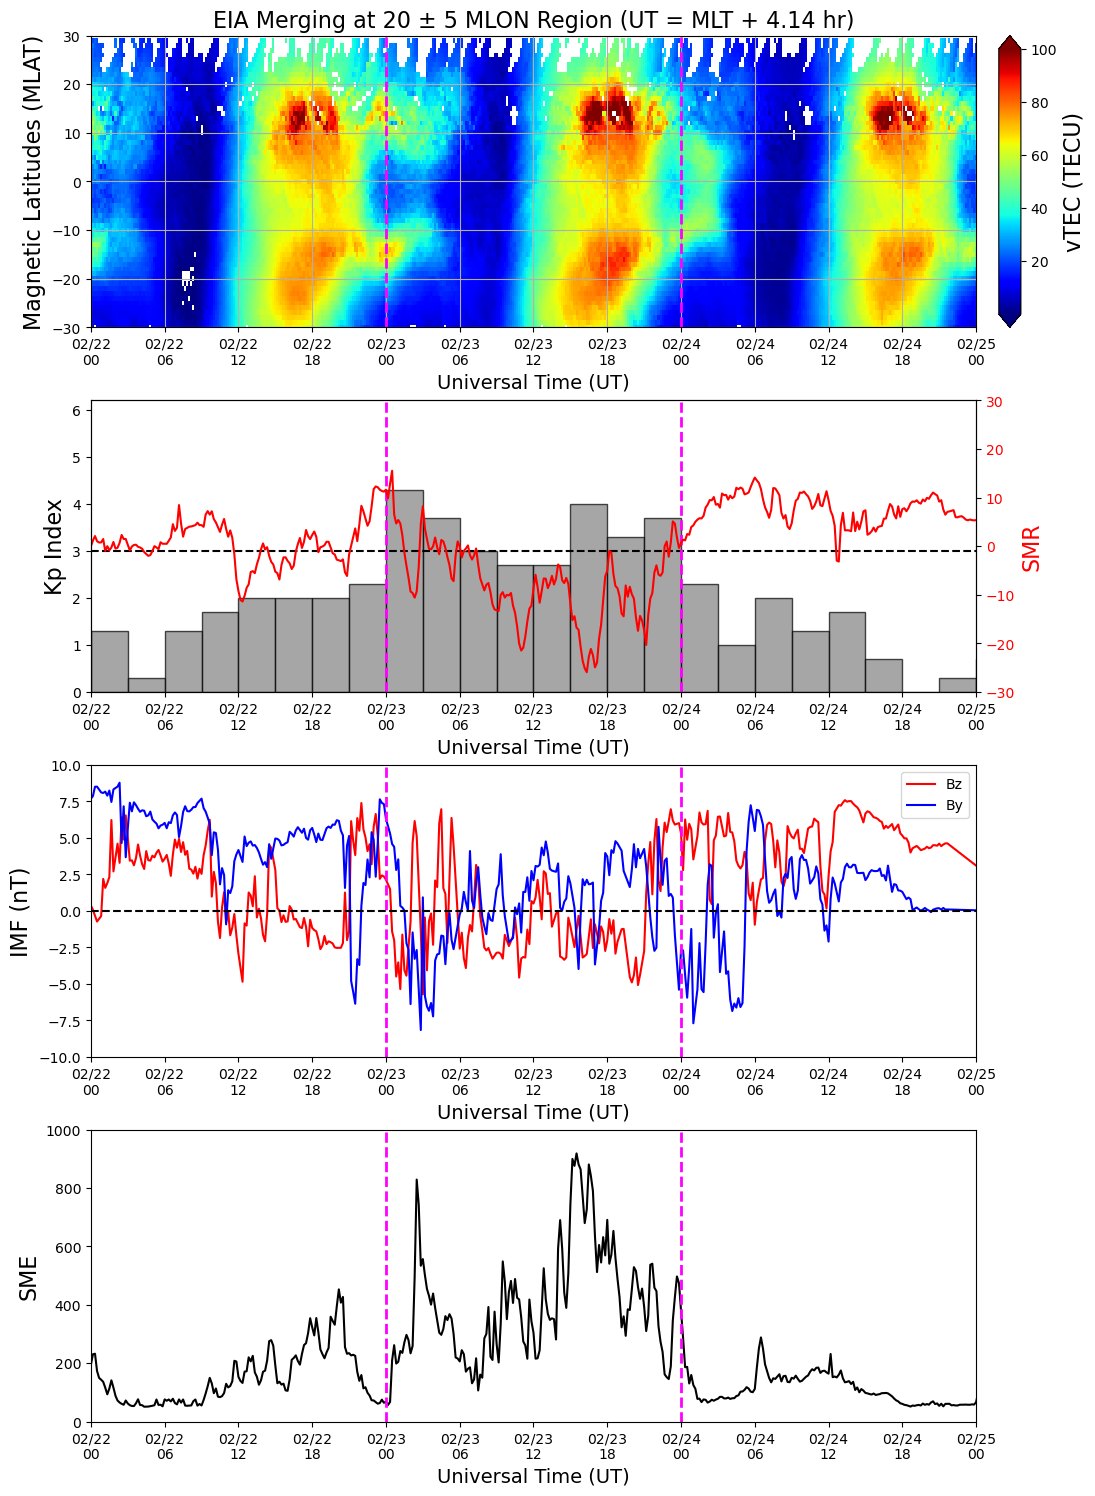

In [29]:
pivot_df = df1.pivot(index='MLAT', columns='time_dt', values='TEC')
X,Y = np.meshgrid(pivot_df.columns.unique(), pivot_df.index.unique())
Z = pivot_df.values.reshape(X.shape)


fig = plt.figure(figsize=(12,18))
specs = fig.add_gridspec(4, 2, width_ratios = [1, 0.025], height_ratios=[1,1,1,1], hspace=0.25, wspace=0.05)

# First Plot - TEC
ax1 = fig.add_subplot(specs[0,0])
pcm = ax1.pcolormesh(X, Y, Z, shading='auto', vmax = 100, cmap='jet')

#ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H\n%m/%d'))
#ax1.xaxis.set_major_locator(mdates.HourLocator(interval=6))
#ax1.set_xticks(pd.date_range(start='2023-02-22', end='2023-02-25', freq='6H'))
#ax1.set_xlabel('Magnetic Local Time (MLT)', fontsize=16)
ax1.set_ylabel('Magnetic Latitudes (MLAT)', fontsize=16)
ax1.set_title(f'EIA Merging at 20 ± 5 MLON Region (UT = MLT + {time_dif} hr)', fontsize = 16)
ax1.set_ylim(-30,30)
ax1.grid(True)
cbar_ax = fig.add_subplot(specs[0,1])
cbar = fig.colorbar(pcm, cax = cbar_ax, label= 'vTEC (TECU)', extend='both')
cbar.set_label('vTEC (TECU)', fontsize = 16)


df2 = df1.drop(columns=['MLAT'])
df2 = df2.groupby(['time_dt']).mean().reset_index()



# Second Plot - kp index and F10.7 values
ax2 = fig.add_subplot(specs[1,0])
if t_coord == 'MLT_dt':
    ax2.bar(kp_binned.index, kp_binned.values, width=pd.Timedelta(hours=3), align="edge", 
            edgecolor="black", color="gray", alpha=0.7, label="Kp Index")
    ax2.set_ylim(0,max(kp_binned.values)+0.5)
elif t_coord == 'DT':
    ax2.bar(kp_binned.time_dt, kp_binned.kp, width=pd.Timedelta(hours=3), align='edge',
           edgecolor='black', color='gray', alpha=0.7, label='Kp Index')
    ax2.set_ylim(0,max(kp_binned.kp)+0.5)
#ax2.hist(dt_kp, bins=np.arange(min(dt_kp), max(dt_kp), np.timedelta64(6, 'h')), weights=kp, color='blue', edgecolor='black', alpha=0.7)  
ax2.set_ylabel('Kp Index', fontsize=16, color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax2.axhline(3, color='black', linestyle='--')

ax2_twin = ax2.twinx()
ax2_twin.plot(df2.time_dt, df2.SMR, label='SMR', color='red')
ax2_twin.set_ylabel('SMR', fontsize=16, color='red')
ax2_twin.tick_params(axis='y', labelcolor='red')
ax2_twin.set_ylim(-30, 30)

# Third Plot - SME and SMR indices 
ax3 = fig.add_subplot(specs[2,0])
df3 = df2[(df2['By'] < 100) & (df2['Bz'] < 100)].reset_index(drop=True)
ax3.plot(df3.time_dt, df3.Bz, color = 'red', label='Bz')
ax3.plot(df3.time_dt, df3.By, color='blue', label='By')
ax3.set_ylabel('IMF (nT)', color='black', fontsize=16)
ax3.tick_params(axis='y', labelcolor='black')
ax3.axhline(0, color = 'black', linestyle='--')
ax3.set_ylim(-10,10)
ax3.legend()
#ax3.grid()

# Fourth plot - SYMH index
ax4 = fig.add_subplot(specs[3,0])
ax4.plot(df2.time_dt, df2.SME, color='black')
ax4.set_ylabel('SME', fontsize=16)
ax4.set_ylim(0,1000)

for ax in [ax1, ax2, ax3, ax4]:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d\n%H'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))
    ax.set_xticks(pd.date_range(start='2023-02-22', end='2023-02-25', freq='6H'))
    # Add vertical lines at specific datetime points
    ax.axvline(pd.Timestamp('2023-02-23 00:00:00'), color='magenta', linestyle='--', linewidth=2)
    ax.axvline(pd.Timestamp('2023-02-24 00:00:00'), color='magenta', linestyle='--', linewidth=2)
    if t_coord == 'MLT_dt':
        ax.set_xlabel('Magnetic Local Time (MLT)', fontsize=14)
    elif t_coord == 'DT':
        ax.set_xlabel('Universal Time (UT)', fontsize=14)
    xlim_start = pd.Timestamp(df2.time_dt.iloc[0])
    xlim_end = pd.Timestamp(df2.time_dt.iloc[-1])
    xlim_start = pd.Timestamp('2023-02-22 00:00:00')
    xlim_end = pd.Timestamp('2023-02-25 00:00:00')
    ax.set_xlim(xlim_start, xlim_end)
    

fig.savefig(f'{work}Qingyu_Cesar_EIA_IHA/EIAMerging/outputs/{start_date}_to_{end_date}.jpg', dpi=300, bbox_inches='tight')
#plt.tight_layout()
plt.show()


# Processing the Fabry-Perot Instrument Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import cartopy.crs as ccrs
from tqdm import tqdm
from apexpy import Apex
import os
import datetime as dt
import importlib as il


In [2]:
# Choose the system: i -> 0:tacc, 1:mac, 2:ganymede
i = 2

if i == 0:
    work = '/work/10028/prasoonv/ls6/repo/sat-interp-tid-analysis/'
    scratch = '/scratch/10028/prasoonv/' 
elif i == 1:
    work = '/Users/prasoonv/repo/sat-interp-tid-analysis/'
    scratch = '/Users/prasoonv/repo/sat-interp-tid-analysis/scratch/'
elif i == 2:
    work = '/home/pxv220016/prasoon/data/sat_interp_repo/repo2/'
    scratch = '/home/pxv220016/scratch/'

import sys
sys.path.append('')
sys.path.append(f'{work}prasoon_utility_programs')
sys.path.append(f'{work}Qingyu_Cesar_EIA_IHA')
import functions

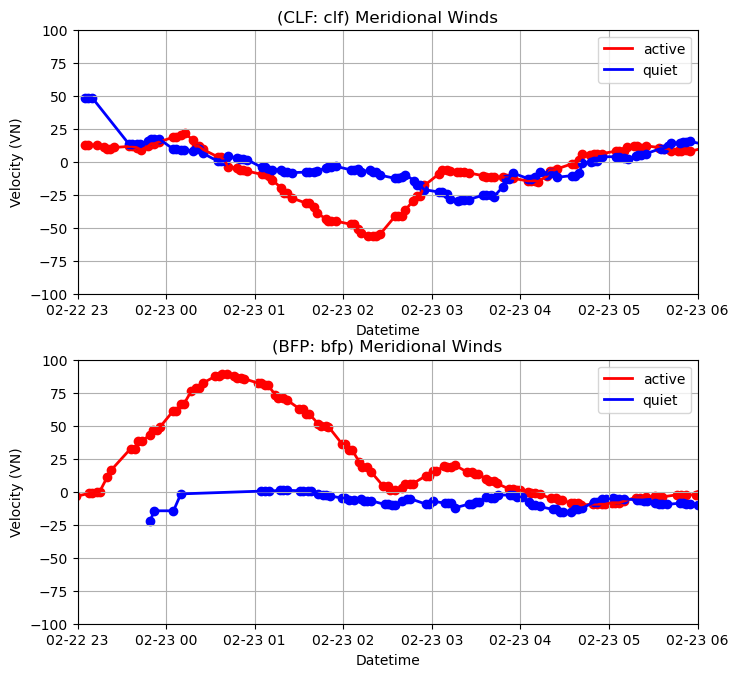

In [3]:
events_list = ['feb_22_24_2023', 'may_9_11_2024']
event = events_list[0]

stations = ['clf', 'bfp']
color = ['blue', 'red']
path = f'{scratch}Qingyu_Cesar_EIA/EIAmerging/fabry_perot_data/'

i = 0
# Plot the time series
fig = plt.figure(figsize=(8, 12))
specs = fig.add_gridspec(3,1, height_ratios=[1,1,1], hspace=0.25)

for s in stations:
    file_path = path + s + '/'
    files_list = os.listdir(file_path)
    files = [file_path + i for i in files_list]

    data = []

    for f in files:
        if f[-4:] != '.txt':
            continue

        #name = f.split('/')[-1][:9]
        save_path = f'{scratch}Qingyu_Cesar_EIA/EIAmerging/fabry_perot_data/{s}.csv'
        
        columns = [
            "YEAR", "MONTH", "DAY", "HOUR", "MIN", "SEC", "RECNO", "KINDAT", "KINST",
            "UT1_UNIX", "UT2_UNIX", "ALTB", "ALTE", "GDLAT", "GLON",
            "VN1", "VN2", "DVN1", "DVN2", "GVN1", "GVN2", "DGVN1", "DGVN2", "FPI_DATAQUAL"
        ]
        df_t = pd.read_csv(f, sep='\s+', names=columns, skiprows=1)
        
        # Relevant columns
        df_t = df_t[["YEAR", "MONTH", "DAY", "HOUR", "MIN", "VN1", "DVN1", "VN2", "DVN2"]]

        df_t = df_t.rename(columns={"YEAR": "year", "MONTH": "month", "DAY": "day", "HOUR": "hour", "MIN": "minute"})
        
        # Combine the columns into a single datetime column
        df_t['DATETIME'] = pd.to_datetime(df_t[["year", "month", "day", "hour", "minute"]])

        df_t = df_t.drop(columns=['year', 'month', 'day', 'hour', 'minute'])
    
        # Drop any rows with NaNs in VN1 or VN2
        #df = df.dropna(subset=["VN1", "VN2"])
        
        data.append(df_t)
    
    ax = fig.add_subplot(specs[i,0])
    i = i + 1

    for df in data:
        
        # Apply smoothing for VN1 (time-based window)
        df = df.set_index('DATETIME')  # Set the datetime column as the index for rolling()
        df['VN1_SMOOTH'] = df['VN1'].rolling('40min', center=True).mean()  # 20-minute rolling window
        df['VN2_SMOOTH'] = df['VN2'].rolling('40min', center=True).mean()  # 20-minute rolling window
        
        # Reset the index for plotting
        df = df.reset_index()
        
        # Save processed data to CSV
        df.to_csv(save_path, index=False)
        #print(f"Processed data saved to {save_path}")

        #t_ref = pd.to_datetime('2023-02-23 00:00:00')
        d_diff = (df.DATETIME[0]).day - 22
        t_diff = pd.Timedelta(days=d_diff)
        
        if d_diff == 0:
            c = 'blue'
            label = 'quiet'
        elif d_diff == 1:
            c = 'red'
            label = 'active'
        updated_time = [(k-t_diff) for k in df.DATETIME]
        
        #print(updated_time)
        
        # Plot smoothed VN1
        #ax.plot(df['DATETIME'], df['VN1_SMOOTH'], color='blue', label='Zonal', linewidth=2)
        ax.plot(updated_time, df['VN2_SMOOTH'], color=c, label=label, linewidth=2)
        ax.scatter(updated_time, df['VN2_SMOOTH'], color=c)
        ax.legend()
    
    # Customize plot
    ax.set_ylim([-100, 100])
    #plt.xlim(df['DATETIME'].min(), df['DATETIME'].max())
    xlim_start = pd.Timestamp('2023-02-22 23:00:00')
    xlim_end = pd.Timestamp('2023-02-23 06:00:00')
    ax.set_xlim(xlim_start, xlim_end)
    ax.set_xlabel("Datetime")
    ax.set_ylabel("Velocity (VN)")
    ax.set_title(f"({s.upper()}: {s}) Meridional Winds")
    ax.grid(True)
    #plt.tight_layout()

# Show plot
save_path1 = f'{work}Qingyu_Cesar_EIA_IHA/EIAMerging/outputs/fabry_perot/meridional_winds.jpg'
plt.savefig(save_path1)
#plt.close()



In [75]:
a = '2023-02-24 23:22:00'
a = pd.to_datetime(a)
print(a.time())

23:22:00


In [107]:
# Example data
dfn = pd.DataFrame({
    'TIMESTAMP': pd.timedelta_range(start='-1 days +23:00:00', periods=24, freq='H'),
    'VALUE': range(24)  # Example values
})

print(dfn)



           TIMESTAMP  VALUE
0  -1 days +23:00:00      0
1    0 days 00:00:00      1
2    0 days 01:00:00      2
3    0 days 02:00:00      3
4    0 days 03:00:00      4
5    0 days 04:00:00      5
6    0 days 05:00:00      6
7    0 days 06:00:00      7
8    0 days 07:00:00      8
9    0 days 08:00:00      9
10   0 days 09:00:00     10
11   0 days 10:00:00     11
12   0 days 11:00:00     12
13   0 days 12:00:00     13
14   0 days 13:00:00     14
15   0 days 14:00:00     15
16   0 days 15:00:00     16
17   0 days 16:00:00     17
18   0 days 17:00:00     18
19   0 days 18:00:00     19
20   0 days 19:00:00     20
21   0 days 20:00:00     21
22   0 days 21:00:00     22
23   0 days 22:00:00     23


# Processing GOLD Data

In [4]:
# file read_single_ni1.py

from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.tri as tri

In [5]:
# Choose the system: i -> 0:tacc, 1:mac, 2:ganymede
i = 2

if i == 0:
    work = '/work/10028/prasoonv/ls6/repo/sat-interp-tid-analysis/'
    scratch = '/scratch/10028/prasoonv/' 
elif i == 1:
    work = '/Users/prasoonv/repo/sat-interp-tid-analysis/'
    scratch = '/Users/prasoonv/repo/sat-interp-tid-analysis/scratch/'
elif i == 2:
    work = '/home/pxv220016/prasoon/data/sat_interp_repo/repo2/'
    scratch = '/home/pxv220016/scratch/'

import sys
sys.path.append('')
sys.path.append(f'{work}prasoon_utility_programs')
sys.path.append(f'{work}Qingyu_Cesar_EIA_IHA')
import functions

In [11]:
events_list = ['feb_22_24_2023', 'may_9_11_2024']
event = events_list[0]

fname = f'{scratch}Qingyu_Cesar_EIA/EIAmerging/GOLD_data/tmp/archive_L1C/2023/055/GOLD_L1C_CHA_DAY_2023_055_18_22_v04_r01_c01.nc'
#fname='/Volumes/Io2/proposal/2025/PostSunsetEIA/data/L1C/050/GOLD_L1C_CHA_NI1_2023_051_00_22_v05_r01_c01.nc'
#fname='/Users/qingyuzhu/Downloads/tmp 2/archive_L1C/2023/051/GOLD_L1C_CHB_NI1_2023_052_00_25_v05_r01_c01.nc'

# Open in read-only mode
nc = Dataset(fname, 'r')

# Get a list of all variables
print(nc.variables.keys())



wavelengths = nc.variables['WAVELENGTH'][:]
#print(wavelengths)

nx,ny,nw=wavelengths.shape

wavelength=np.zeros(nw)
for i in range(nw):
    
    wavelength[i]=np.nanmean(wavelengths[:,:,i])

idx_1356 = np.argmin(np.abs(wavelength - 135.6))


grid_ew = nc.variables['GRID_EW'][:] * 10
grid_ns = nc.variables['GRID_NS'][:] * 10

radiance = nc.variables['RADIANCE'][:]
em_1356 = radiance[:,:, idx_1356]


sza=nc.variables['SOLAR_ZENITH_ANGLE'][:]

em_1356[sza<=95]=np.nan

# Close the file when done
nc.close()

#%%

# Flatten your 2D arrays into 1D:
x = grid_ew.ravel()       # shape (N,)
y = grid_ns.ravel()       # shape (N,)
z = em_1356.ravel()       # shape (N,)

print("grid_ew shape:", grid_ew.shape)
print("grid_ns shape:", grid_ns.shape)
print("em_1356 shape:", em_1356.shape)

# Remove any points where x, y, or z is NaN
print(len(x), len(y), len(z))
mask = np.isnan(x) | np.isnan(y) | np.isnan(z)
x_valid = x[~mask]
y_valid = y[~mask]
z_valid = z[~mask]

# Create a triangulation from these scattered points
triang = tri.Triangulation(x_valid, y_valid)

# Plot with tripcolor (each triangle is colored by z)
plt.figure(figsize=(8,6))
tc = plt.tripcolor(
    triang, z_valid, 
    shading='flat',        # or 'gouraud' for smooth shading
    cmap='viridis', 
    vmin=0, vmax=400
)
plt.colorbar(tc, label='Radiance @ 135.6 nm')
plt.title("135.6 nm Emission (Tripcolor Plot)")
plt.xlabel("grid_ew")
plt.ylabel("grid_ns")
plt.show()

#%%

# Suppose grid_ew.shape, grid_ns.shape, em_1356.shape == (nx, ny)
# Identify rows/columns that are fully valid:
valid_rows = ~np.isnan(grid_ew).all(axis=1)
valid_cols = ~np.isnan(grid_ew).all(axis=0)

# Subset your arrays if that makes sense in your data model:
grid_ew_sub = grid_ew[valid_rows][:, valid_cols]
grid_ns_sub = grid_ns[valid_rows][:, valid_cols]
em_1356_sub = em_1356[valid_rows][:, valid_cols]

# Now these sub-arrays (hopefully) contain no NaNs in x or y
plt.figure()
plt.pcolormesh(grid_ew_sub, grid_ns_sub, em_1356_sub, shading='auto', vmin=0, vmax=400)
plt.colorbar()
plt.show()

dict_keys(['GRID_EW', 'GRID_NS', 'GRID_LAT', 'GRID_LON', 'TIME_ET', 'TIME_UTC', 'L1B_TIME_BINS_PER_GRID', 'L1B_PIXELS_PER_GRID', 'QUALITY_FLAG', 'WAVELENGTH', 'RAW_COUNT', 'RAW_COUNT_RANDOM_UNC', 'CORRECTED_COUNT', 'CORRECTED_COUNT_SYSTEMATIC_UNC', 'CORRECTED_COUNT_RANDOM_UNC', 'RADIANCE', 'RADIANCE_SYSTEMATIC_UNC', 'RADIANCE_RANDOM_UNC', 'BACKGROUND_COUNTS', 'REFERENCE_POINT_LAT', 'REFERENCE_POINT_LON', 'TANGENT_HEIGHT', 'RAY_SOLAR_PHASE_ANGLE', 'RAY_NADIR_ANGLE', 'EMISSION_ANGLE', 'SOLAR_ZENITH_ANGLE'])
grid_ew shape: (92,)
grid_ns shape: (104,)
em_1356 shape: (104, 92)
92 104 9568


ValueError: operands could not be broadcast together with shapes (92,) (104,) 

In [38]:
# file show_two_ni1_simple.py

from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np


dict_keys(['GRID_EW', 'GRID_NS', 'GRID_LAT', 'GRID_LON', 'TIME_ET', 'TIME_UTC', 'L1B_TIME_BINS_PER_GRID', 'L1B_PIXELS_PER_GRID', 'QUALITY_FLAG', 'WAVELENGTH', 'RAW_COUNT', 'RAW_COUNT_RANDOM_UNC', 'CORRECTED_COUNT', 'CORRECTED_COUNT_SYSTEMATIC_UNC', 'CORRECTED_COUNT_RANDOM_UNC', 'RADIANCE', 'RADIANCE_SYSTEMATIC_UNC', 'RADIANCE_RANDOM_UNC', 'BACKGROUND_COUNTS', 'REFERENCE_POINT_LAT', 'REFERENCE_POINT_LON', 'TANGENT_HEIGHT', 'RAY_SOLAR_PHASE_ANGLE', 'RAY_NADIR_ANGLE', 'EMISSION_ANGLE', 'SOLAR_ZENITH_ANGLE'])
grid_ew_sub shape: (55, 91)
grid_ns_sub shape: (55, 91)
em_1356_sub shape: (55, 91)


/tmp/ipykernel_27880/3826863378.py:54: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(grid_ew_sub, grid_ns_sub, em_1356_sub, shading='auto', vmin=0, vmax=600)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/qingyuzhu/Downloads/tmp 2/archive_L1C/2023/051/GOLD_L1C_CHB_NI1_2023_052_00_25_v05_r01_c01.nc'

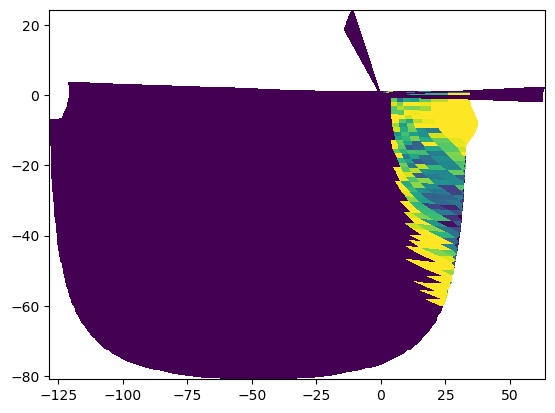

In [40]:
# NH
fname=f'{scratch}Qingyu_Cesar_EIA/EIAmerging/GOLD_data/tmp/archive_L1C/2023/055/GOLD_L1C_CHA_DAY_2023_055_18_22_v04_r01_c01.nc'

# Open in read-only mode
nc = Dataset(fname, 'r')

# Get a list of all variables
print(nc.variables.keys())



wavelengths = nc.variables['WAVELENGTH'][:]

nx,ny,nw=wavelengths.shape

wavelength=np.zeros(nw)
for i in range(nw):
    
    wavelength[i]=np.nanmean(wavelengths[:,:,i])

idx_1356 = np.argmin(np.abs(wavelength - 135.6))


grid_ew = nc.variables['REFERENCE_POINT_LON'][:] * 1
grid_ns = nc.variables['REFERENCE_POINT_LAT'][:] * 1

radiance = nc.variables['RADIANCE'][:]
em_1356 = radiance[:,:, idx_1356]


sza=nc.variables['SOLAR_ZENITH_ANGLE'][:]

em_1356[sza<=95]=np.nan

# Close the file when done
nc.close()

valid_rows = ~np.isnan(grid_ew).all(axis=1)
valid_cols = ~np.isnan(grid_ew).all(axis=0)

# Subset your arrays if that makes sense in your data model:
grid_ew_sub = grid_ew[valid_rows][:, valid_cols]
grid_ns_sub = grid_ns[valid_rows][:, valid_cols]
em_1356_sub = em_1356[valid_rows][:, valid_cols]
grid_ew_sub = np.nan_to_num(grid_ew_sub, nan=0.0, posinf=0.0, neginf=0.0)
grid_ns_sub = np.nan_to_num(grid_ns_sub, nan=0.0, posinf=0.0, neginf=0.0)
em_1356_sub = np.nan_to_num(em_1356_sub, nan=0.0, posinf=0.0, neginf=0.0)
print("grid_ew_sub shape:", grid_ew_sub.shape)
print("grid_ns_sub shape:", grid_ns_sub.shape)
print("em_1356_sub shape:", em_1356_sub.shape)

# Now these sub-arrays (hopefully) contain no NaNs in x or y
plt.figure()
plt.pcolormesh(grid_ew_sub, grid_ns_sub, em_1356_sub, shading='auto', vmin=0, vmax=600)


#%% SH
fname='/Users/qingyuzhu/Downloads/tmp 2/archive_L1C/2023/051/GOLD_L1C_CHB_NI1_2023_052_00_25_v05_r01_c01.nc'

# Open in read-only mode
nc = Dataset(fname, 'r')

# Get a list of all variables
print(nc.variables.keys())



wavelengths = nc.variables['WAVELENGTH'][:]

nx,ny,nw=wavelengths.shape

wavelength=np.zeros(nw)
for i in range(nw):
    
    wavelength[i]=np.nanmean(wavelengths[:,:,i])

idx_1356 = np.argmin(np.abs(wavelength - 135.6))


grid_ew = nc.variables['REFERENCE_POINT_LON'][:] * 1
grid_ns = nc.variables['REFERENCE_POINT_LAT'][:] * 1

radiance = nc.variables['RADIANCE'][:]
em_1356 = radiance[:,:, idx_1356]


sza=nc.variables['SOLAR_ZENITH_ANGLE'][:]

em_1356[sza<=95]=np.nan

# Close the file when done
nc.close()

valid_rows = ~np.isnan(grid_ew).all(axis=1)
valid_cols = ~np.isnan(grid_ew).all(axis=0)

# Subset your arrays if that makes sense in your data model:
grid_ew_sub = grid_ew[valid_rows][:, valid_cols]
grid_ns_sub = grid_ns[valid_rows][:, valid_cols]
em_1356_sub = em_1356[valid_rows][:, valid_cols]

# Now these sub-arrays (hopefully) contain no NaNs in x or y

plt.pcolormesh(grid_ew_sub, grid_ns_sub, em_1356_sub, shading='auto', vmin=0, vmax=600)


plt.xlim(-80,0)
plt.ylim(-40,40)
plt.colorbar()

plt.show()
